In [0]:
# Create the directory
dbutils.fs.mkdirs("/FileStore/tables/")

True

In [0]:
%sh
curl -o /dbfs/FileStore/tables/HRDataset_v14.csv https://raw.githubusercontent.com/nogibjj/ZT-DE-week8-miniproject8/main/HRDataset_v14.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76857  100 76857    0     0   253k      0 --:--:-- --:--:-- --:--:--  253k


In [0]:
# Verify the file
display(dbutils.fs.ls("/FileStore/tables"))

path,name,size,modificationTime
dbfs:/FileStore/tables/HRDataset_v14.csv,HRDataset_v14.csv,76857,1702321159000


In [0]:
df = spark.read.csv("dbfs:/FileStore/tables/HRDataset_v14.csv", header=True, inferSchema=True)

In [0]:
### Error handling part ####
try:
    # Check for missing values in 'Employee_Name' column
    if df.filter(df["Employee_Name"].isNull()).count() > 0:
        raise ValueError("Data contains null values in 'Employee_Name'")
    
    # Additional data processing steps...
    
except ValueError as ve:
    print("Data Validation Error:", ve)
except Exception as e:
    print("An error occurred:", e)


In [0]:
###### ABOVE IS DATA INGESTION JOB IS COMPLETED ######

In [0]:
##### HERE IS THE DATA TRANSFORMATON WITH SPARK SQL ######

# 1. Register 'df' as a temporary view
df.createOrReplaceTempView("hr_data")

In [0]:
# 2. Perform SQL queries for transformation

# Query for the Average Salary by Department
avg_salary_dept = spark.sql("""
    SELECT Department, AVG(Salary) as AverageSalary
    FROM hr_data
    GROUP BY Department
""")
avg_salary_dept.show()

+--------------------+------------------+
|          Department|     AverageSalary|
+--------------------+------------------+
|               Sales| 69061.25806451614|
|   Production       |59953.545454545456|
|       Admin Offices| 71791.88888888889|
|    Executive Office|          250000.0|
|Software Engineering| 94989.45454545454|
|               IT/IS|          97064.64|
+--------------------+------------------+



In [0]:
# Query for Counting the number of employees based on their marital status
count_by_marital_status = spark.sql("""
    SELECT MaritalDesc, COUNT(*) as EmployeeCount
    FROM hr_data
    GROUP BY MaritalDesc
""")
count_by_marital_status.show()

+-----------+-------------+
|MaritalDesc|EmployeeCount|
+-----------+-------------+
|  Separated|           12|
|    Married|          124|
|   Divorced|           30|
|    Widowed|            8|
|     Single|          137|
+-----------+-------------+



In [0]:
# Select employees with High Salaries
transformed_salary_df = spark.sql("""
    SELECT Employee_Name, Position, Salary
    FROM hr_data
    WHERE Salary > 70000
""")

# Select employees by department and performance score
transformed_df = spark.sql("""
    SELECT Employee_Name, Department, PerformanceScore
    FROM hr_data
    WHERE PerformanceScore = 'Exceeds'
""")

In [0]:
##### HERE IS THE DATA STORAGE IN LAKE #####

# Save the transformed data to Delta Lake for efficient storage and additional functionalitites like versioning
transformed_df.write.format("delta").mode("overwrite").save("/delta/HRDatasetTransformed")

transformed_salary_df.write.format("delta").mode("overwrite").save("/delta/HRDatasetSalaryTransformed")


In [0]:
##### HERE IS THE DATA VISUALIZATION #####

pd_df = transformed_df.toPandas()
pd_salary_df = transformed_salary_df.toPandas()
# Visualization code using Matplotlib/Seaborn

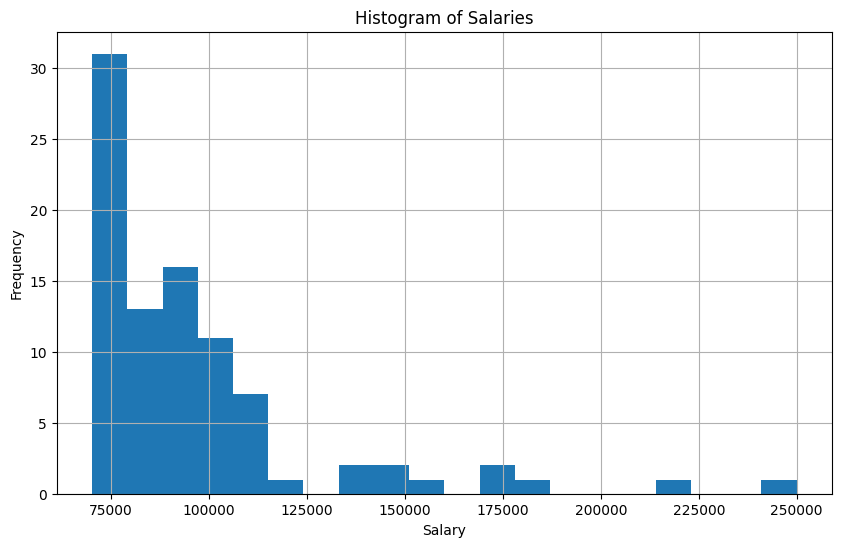

In [0]:
# plotting a histogram of salaries

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
pd_salary_df['Salary'].hist(bins=20)
plt.title('Histogram of Salaries')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()


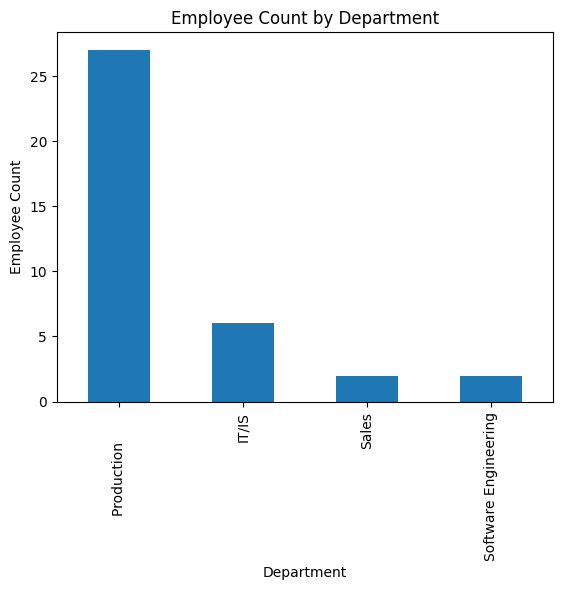

In [0]:
# Bar Chart of Employee count by Department

department_counts = pd_df['Department'].value_counts()
department_counts.plot(kind='bar')
plt.title('Employee Count by Department')
plt.xlabel('Department')
plt.ylabel('Employee Count')
plt.show()

### Conclusion and Recommendation
The visualizations indicate a significant concentration of employees within the Production department, suggesting it is a central operational area of the company. This could imply a focus on manufacturing or hands-on work, requiring a larger workforce. On the other hand, the Histogram of Salaries reveals a wide range of compensation, with a substantial number of employees clustered at the lower end of the salary spectrum and fewer individuals earning higher wages. This may point to a traditional hierarchical structure with many entry-level or mid-level positions and fewer higher-paying roles. Management might consider reviewing salary distributions to ensure fair and competitive compensation, particularly to retain key talent in higher-skilled positions.